In [1]:
# importing libraries
import glob
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.models import load_model
from keras.optimizers import Adam
import IPython.display as ipd


In [2]:
# loading a audio sample from dataset
audio_file = "E:\\MLSP\\archive\\cv-other-dev\\cv-other-dev\\sample-000000.mp3"
ipd.Audio(audio_file)


In [3]:
signal, sr = librosa.load(audio_file)


In [4]:
print("signal shpe:",signal.shape)

signal shpe: (70913,)


In [5]:
mfccs = librosa . feature . mfcc (y=signal, n_mfcc =13, sr=sr)
print("mfcc shape:",mfccs.shape) # rows = no. of coefficients and columns = no. of frames

mfcc shape: (13, 139)


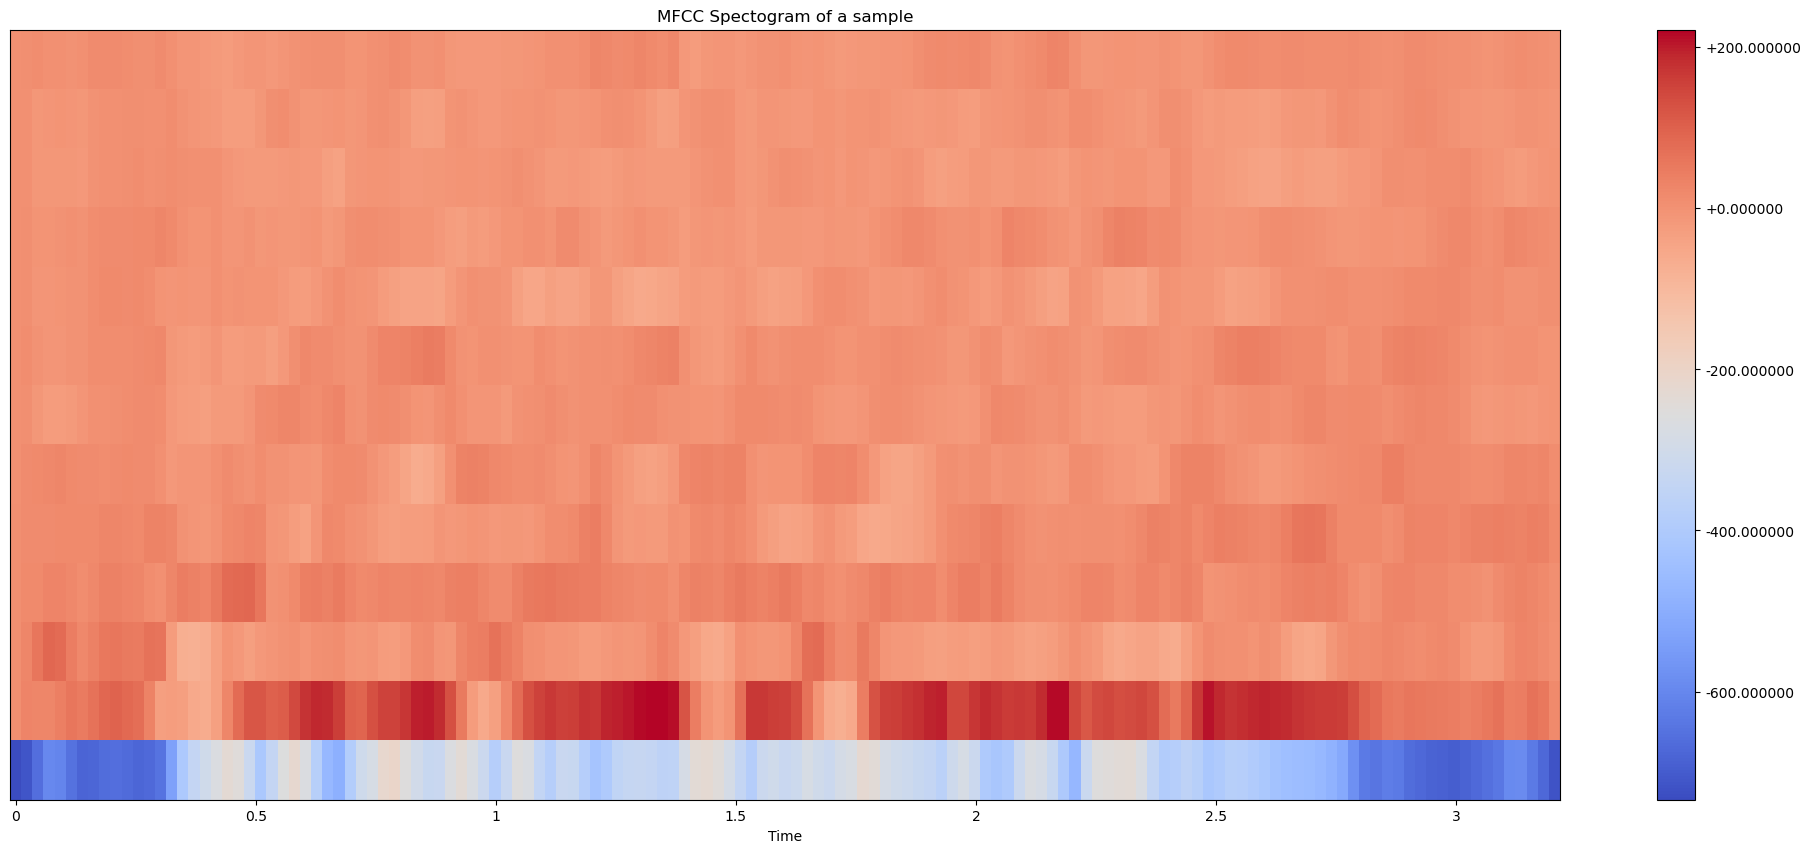

In [6]:
#MFCC Spectogram of a sample
plt.figure(figsize=(25,10))
librosa.display.specshow(mfccs,x_axis='time', sr=sr)
plt.colorbar(format='%+2f')
plt.title("MFCC Spectogram of a sample")
plt.show()

In [7]:
def extract_feature ( file_name , ** kwargs ) :
    """
        Extract mfcc and mel - spectrogram from audio file `file_name `
        e . g :
        `features = extract_feature ( path , mel = True , mfcc = True )`
    """
    mfcc = kwargs . get (" mfcc ")
    mel = kwargs . get (" mel ")
    X , sample_rate = librosa . core . load ( file_name )

    result = np . array ([])
    if mfcc :
        mfccs = np . mean ( librosa . feature . mfcc ( y =X , sr = sample_rate , n_mfcc =40) .T ,axis =0)
        result = np . hstack (( result , mfccs ) )
    if mel :
        mel = np . mean ( librosa . feature . melspectrogram ( y =X , sr = sample_rate ) .T ,axis =0)
    result = np . hstack (( result , mel ) )
    return result

In [8]:
dirname = "data"

if not os.path.isdir(dirname):
    os.mkdir(dirname)


csv_files = glob.glob("*.csv")

for j, csv_file in enumerate(csv_files):
    print("[+] Preprocessing", csv_file)
    df = pd.read_csv(csv_file)
    # only take filename and gender columns
    new_df = df[["filename", "gender"]]
    print("Previously:", len(new_df), "rows")
    # take only male & female genders (i.e droping NaNs & 'other' gender)
    new_df = new_df[np.logical_or(new_df['gender'] == 'female', new_df['gender'] == 'male')]
    print("Now:", len(new_df), "rows")
    new_csv_file = os.path.join(dirname, csv_file)
    # save new preprocessed CSV 
    new_df.to_csv(new_csv_file, index=False)
    # get the folder name
    folder_name, _ = csv_file.split(".")
    audio_files = glob.glob(f"{folder_name}/{folder_name}/*")
    all_audio_filenames = set(new_df["filename"])
    for i, audio_file in tqdm(list(enumerate(audio_files)), f"Extracting features of {folder_name}"):
        splited = os.path.split(audio_file)
        # audio_filename = os.path.join(os.path.split(splited[0])[-1], splited[-1])
        audio_filename = f"{os.path.split(splited[0])[-1]}/{splited[-1]}"
        # print("audio_filename:", audio_filename)
        if audio_filename in all_audio_filenames:
            # print("Copyying", audio_filename, "...")
            src_path = f"{folder_name}/{audio_filename}"
            target_path = f"{dirname}/{audio_filename}"
            #create that folder if it doesn't exist
            if not os.path.isdir(os.path.dirname(target_path)):
                os.mkdir(os.path.dirname(target_path))
            features = extract_feature(src_path, mel=True)
            target_filename = target_path.split(".")[0]
            np.save(target_filename, features)
            # shutil.copyfile(src_path, target_path)

[+] Preprocessing balanced-all.csv
Previously: 66938 rows
Now: 66938 rows


Extracting features of balanced-all: 0it [00:00, ?it/s]


In [9]:
label2int = {
    "male": 1,
    "female": 0
}

In [10]:
def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("balanced-all.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y



In [11]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }


In [12]:
def create_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model


In [38]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)
n_female_samples = len(df[df['gender'] == 'female'])
# construct the model
model = create_model()

# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 100

#shape of train,valid and test list
print("Shape of training set :",data["X_train"].shape)
print("shape of validation dataset :",data["X_valid"].shape)
print("Shape of training data labels :",data["y_train"].shape)
print("Shape of validation data labels :", data["y_valid"].shape)
print("Shape of test data samples :",data["X_test"].shape)
print("Shape of test data labels :",data["y_test"].shape)


history = model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, 
                    validation_data=(data["X_valid"], data["y_valid"]), callbacks=[tensorboard, early_stopping])

# Print model summary to get input and output shapes
print("Model Summary:")
model.summary()

C:\Users\iamsh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,545 (611.50 KB)

 Trainable params: 156,545 (611.50 KB)

 Non-trainable params: 0 (0.00 B)

Shape of training set : (54219, 128)
shape of validation dataset : (6025, 128)
Shape of training data labels : (54219, 1)
Shape of validation data labels : (6025, 1)
Shape of test data samples : (6694, 128)
Shape of test data labels : (6694, 1)
Epoch 1/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7152 - loss: 0.6715 - val_accuracy: 0.8370 - val_loss: 0.4173
Epoch 2/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8315 - loss: 0.4262 - val_accuracy: 0.8642 - val_loss: 0.3555
Epoch 3/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8433 - loss: 0.3968 - val_accuracy: 0.8745 - val_loss: 0.3216
Epoch 4/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8608 - loss: 0.3649 - val_accuracy: 0.8795 - val_loss: 0.3071
Epoch 5/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8675 - loss: 0.3436 - val_accuracy: 0.8798 - val_loss: 0.3094
Epoch 6/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8694 - loss: 0.3363 - val_accuracy: 0.8832

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 469,637 (1.79 MB)

 Trainable params: 156,545 (611.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 313,092 (1.19 MB)

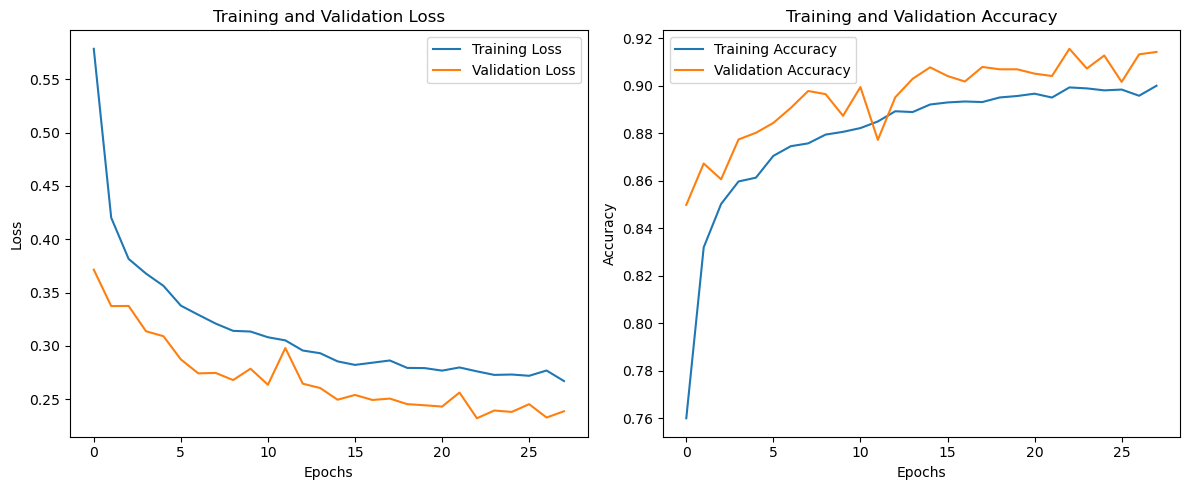

Evaluating the model using 6694 samples...
Loss: 2.8377
Accuracy: 48.45%


In [33]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Save the model
model.save("results/model.h5")

# Evaluate the model
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

In [34]:
# Load the model

model = load_model("results/model.h5")

# Define the directory where the test data is stored
test_data_dir = "data"

# Load the test data features and labels
X_test, y_test = load_data(vector_length=128)

# Make predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) #converts predicted probabilities y_pred_prob into binary predictions y_predS


print("Shape of test data :",X_test.shape)
print("Shape of test label :",y_test.shape)
print("Shape of preicted test data :", y_pred.shape)

print("predicted probabilities :",y_pred_prob.shape)


2092/2092 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Shape of test data : (66938, 128)
Shape of test label : (66938, 1)
Shape of preicted test data : (66938, 1)
predicted probabilities : (66938, 1)


In [36]:
print("predicted probabilities :\n",y_pred_prob)

predicted probabilities :
 [[0.95648575]
 [0.55164516]
 [0.92524266]
 ...
 [0.81184524]
 [0.838637  ]
 [0.97379637]]


[[   19 33450]
 [   35 33434]]


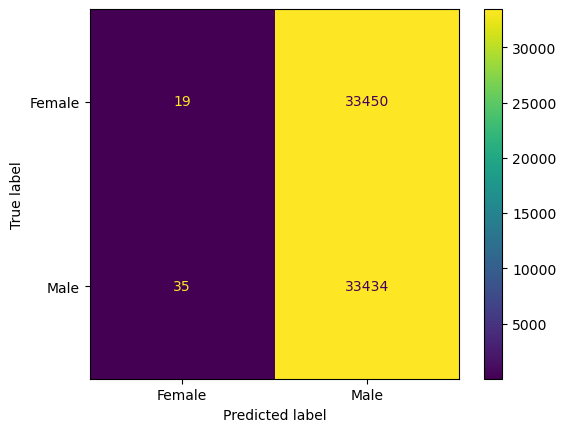

In [37]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
# Plot confusion matrix
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Female', 'Male'])
cm_disp.plot()

In [18]:
print("true positive :",conf_matrix[0][0])
print("false positive :",conf_matrix[0][1])
print("false negative :",conf_matrix[1][0])
print("true negative :",conf_matrix[1][1])

true positive : 30841
false positive : 2628
false negative : 3378
true negative : 30091


In [19]:
matrix1=y_pred
flattened_list1 = []
for sublist in matrix1:
    for item in sublist:
        flattened_list1.append(item)
print(flattened_list1)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
y_test = y_test.astype(int)
matrix2=y_test
flattened_list2 = []
for sublist in matrix2:
    for item in sublist:
        flattened_list2.append(item)

print(flattened_list2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 